## Preparation

installation

In [ ]:
!pip install mediapipe

In [ ]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Face cropping

In [ ]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [ ]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import os
from PIL import Image




# STEP 2: Create a FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# Loop through all files in the folder

start =451
end=501
for n in range(11,13):
  start=start+50
  end=end+50
  mainFolder = 'IP'+"{:02d}".format(n)
  for i in range(start,end):

    folder_path='/content/drive/MyDrive/AFEW_VA/'+mainFolder+'/'+"{:03d}".format(i)

    for file_name in os.listdir(folder_path):
        IMAGE_FILE= os.path.join(folder_path, file_name)
        if os.path.isfile(IMAGE_FILE) and file_name.endswith('.png'):

            # STEP 3: Load the input image.
            image = mp.Image.create_from_file(IMAGE_FILE)

            # STEP 4: Detect faces in the input image.
            detection_result = detector.detect(image)

            # Open the original image
            image = Image.open(IMAGE_FILE)

            if detection_result.detections:
                # Get the bounding box coordinates from the detection result
                detection = detection_result.detections[0]
                x, y, width, height = detection.bounding_box.origin_x, detection.bounding_box.origin_y, detection.bounding_box.width, detection.bounding_box.height

                # Crop the image using the bounding box coordinates
                cropped_image = image.crop((x, y, x + width, y + height))

                # Create the directory for cropped images if it doesn't exist
                # directory =  "/content/001"+ "_cropped"
                directory =  folder_path+ "_cropped"
                if not os.path.exists(directory):
                    os.makedirs(directory)

                # Construct the path for the cropped image
                cropped_file_path = os.path.join(directory, file_name)

                # Save the cropped image

                cropped_image.save(cropped_file_path)


# ***ANN Approach***

### Relative and normalized landmarks

In [ ]:
import os
import json


def normalize_landmarks(landmarks):


    ref_landmark_1 = np.array(landmarks[36])  # Left eye corner
    ref_landmark_2 = np.array(landmarks[45])  # Right eye corner

    # Calculate the origin (center of the reference landmarks)
    origin = (ref_landmark_1 + ref_landmark_2) / 2

    # Calculate the scaling factor (distance between the reference landmarks)
    scaling_factor = np.linalg.norm(ref_landmark_2 - ref_landmark_1)

    # Translate and scale the landmarks
    normalized_landmarks = [(np.array(landmark) - origin) / scaling_factor for landmark in landmarks]

    # Convert landmarks from NumPy arrays to Python lists
    normalized_landmarks = [landmark.tolist() for landmark in normalized_landmarks]

    return normalized_landmarks


def update_landmarks_in_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    new_data = data.copy()

    frames = data.get("frames", {})

    for frame_key, frame_data in frames.items():
        landmarks = frame_data.get("landmarks", [])

        if landmarks:
            # origin_x, origin_y = landmarks[0]
            # relative_landmarks = [[x - origin_x, y - origin_y] for x, y in landmarks]
            normalized_landmarks = normalize_landmarks(landmarks)
            new_data["frames"][frame_key]["landmarks"] = normalized_landmarks
            normalized_landmarks = [list(landmark) for landmark in normalized_landmarks]
            # print(normalized_landmarks)
    new_file_path = os.path.splitext(file_path)[0] + '_normalized.json'

    with open(new_file_path, 'w') as new_file:
        json.dump(new_data, new_file, indent=2)
        print(f"Created new file with updated landmarks: {new_file_path}")

# Function to traverse through directories and update JSON files
def update_landmarks_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json') and not file.endswith('_relative.json') and not file.endswith('_normalized.json'):
                file_path = os.path.join(root, file)
                update_landmarks_in_file(file_path)

# Main function
def main():
    # Define the root directory
    root_directory = '/content/drive/MyDrive/AFEW_VA'  # Update this with your root directory

    # Update landmarks in all JSON files within the root directory and its subdirectories
    update_landmarks_in_directory(root_directory)

if __name__ == "__main__":
    main()


### Valece and arousal using normal ANN regression

**Valence**

In [2]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.decomposition import PCA
pca = PCA(n_components=50)

# Function to load data from JSON files and split into training and testing sets
def load_data_from_files(directory, test_size=0.2):
    X, y_valence = [], []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('_normalized.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as file:
                    data = json.load(file)

                for frame_data in data["frames"].values():
                    landmarks = frame_data.get("landmarks", [])
                    valence = frame_data.get("valence", 0)

                    if landmarks:  # Ensure landmarks are not empty
                        X.append(np.array(landmarks).flatten())  # Flatten landmarks
                        y_valence.append(valence)
                        # print(X)

    X = np.array(X)
    y_valence = np.array(y_valence)

    # Split data into train and test sets
    X_train, X_test, y_valence_train, y_valence_test = \
        train_test_split(X, y_valence, test_size=test_size, random_state=42)

    return X_train, X_test, y_valence_train, y_valence_test

# Function to build ANN model
def build_ann_model(input_shape):
  model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer with 2 neurons for valence and arousal
    ])

  # opti = Adam(learning_rate=0.01)

  model.compile(optimizer='adam', loss='mean_squared_error')
  return model
# Main function
def main():
    # Define the root directory
    root_directory = '/content/drive/MyDrive/AFEW_VA'  # Update this with your root directory

    # Load data from JSON files
    X_train, X_test, y_valence_train, y_valence_test = load_data_from_files(root_directory)


    # from sklearn.decomposition import PCA
    # pca = PCA(n_components=10)  # Adjust the number of components as needed
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Build ANN model
    input_shape = X_train.shape[1:]
    model = build_ann_model(input_shape)

    # Train the model
    model.fit(X_train, [y_valence_train], epochs=100, batch_size=32, validation_split=0.1)

    # Evaluate the model
    predictions = model.predict(X_test)

    # Calculate evaluation metrics
    mse_valence = mean_squared_error(y_valence_test, predictions[:, 0])
    mae_valence = mean_absolute_error(y_valence_test, predictions[:, 0])
    rmse_valence = np.sqrt(mse_valence)
    r2_valence = r2_score(y_valence_test, predictions[:, 0])

    print("Valence Metrics:")
    print("Mean Squared Error:", mse_valence)
    print("Mean Absolute Error:", mae_valence)
    print("Root Mean Squared Error:", rmse_valence)
    print("R-squared:", r2_valence)

    model_path = '/content/Models/valence_model.h5'

    # Save the model
    model.save(model_path)

    print("Model saved successfully at:", model_path)

if __name__ == "__main__":
    main()

Epoch 1/100
677/677 [==============================] - 5s 4ms/step - loss: 6.3988 - val_loss: 5.1464
Epoch 2/100
677/677 [==============================] - 3s 4ms/step - loss: 4.6637 - val_loss: 4.3833
Epoch 3/100
677/677 [==============================] - 2s 3ms/step - loss: 3.8644 - val_loss: 3.8294
Epoch 4/100
677/677 [==============================] - 2s 3ms/step - loss: 3.2803 - val_loss: 3.1916
Epoch 5/100
677/677 [==============================] - 2s 3ms/step - loss: 2.8624 - val_loss: 3.3639
Epoch 6/100
677/677 [==============================] - 2s 3ms/step - loss: 2.5024 - val_loss: 2.7940
Epoch 7/100
677/677 [==============================] - 2s 3ms/step - loss: 2.1696 - val_loss: 2.7377
Epoch 8/100
677/677 [==============================] - 2s 4ms/step - loss: 1.9427 - val_loss: 2.2038
Epoch 9/100
677/677 [==============================] - 3s 4ms/step - loss: 1.7818 - val_loss: 2.1626
Epoch 10/100
677/677 [==============================] - 2s 3ms/step - loss: 1.6269 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Arousal**

In [ ]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.decomposition import PCA
pca = PCA(n_components=50)

# Function to load data from JSON files and split into training and testing sets
def load_data_from_files(directory, test_size=0.2):
    X, y_arousal = [], []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('_normalized.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as file:
                    data = json.load(file)

                for frame_data in data["frames"].values():
                    landmarks = frame_data.get("landmarks", [])
                    arousal = frame_data.get("arousal", 0)

                    if landmarks:  # Ensure landmarks are not empty
                        X.append(np.array(landmarks).flatten())  # Flatten landmarks
                        y_arousal.append(arousal)

    X = np.array(X)
    # print(X)
    y_arousal = np.array(y_arousal)

    # Split data into train and test sets
    X_train, X_test, y_arousal_train, y_arousal_test = \
        train_test_split(X, y_arousal, test_size=test_size, random_state=42)

    return X_train, X_test, y_arousal_train, y_arousal_test

# Function to build ANN model
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer with 1 neurons for arousal
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Main function
def main():
    # Define the root directory
    root_directory = '/content/drive/MyDrive/AFEW_VA'  # Update this with your root directory

    # Load data from JSON files
    X_train, X_test, y_arousal_train, y_arousal_test = load_data_from_files(root_directory)

    # Standardize input features separately for training and testing sets
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Build ANN model
    input_shape = X_train.shape[1:]
    model = build_ann_model(input_shape)

    # Train the model
    model.fit(X_train, [y_arousal_train], epochs=100, batch_size=32, validation_split=0.1)

    # Evaluate the model
    predictions = model.predict(X_test)

    # Calculate evaluation metrics

    mse_arousal = mean_squared_error(y_arousal_test, predictions[:, 0])
    mae_arousal = mean_absolute_error(y_arousal_test, predictions[:, 0])
    rmse_arousal = np.sqrt(mse_arousal)
    r2_arousal = r2_score(y_arousal_test, predictions[:, 0])

    print("\nArousal Metrics:")
    print("Mean Squared Error:", mse_arousal)
    print("Mean Absolute Error:", mae_arousal)
    print("Root Mean Squared Error:", rmse_arousal)
    print("R-squared:", r2_arousal)

    model_path = '/content/Models/arousal_model.h5'

    # Save the model
    model.save(model_path)

    print("Model saved successfully at:", model_path)


if __name__ == "__main__":
    main()

### *Valance and arousal using feature*

**Engineering feature**

In [5]:
import os
import json
from sklearn.model_selection import train_test_split
import numpy as np
from math import atan2, pi
from sklearn.decomposition import PCA

def calculate_distances(landmarks):

    eye_distance = np.linalg.norm(landmarks[45] - landmarks[36])  # Distance between eye corners
    mouth_distance = np.linalg.norm(landmarks[54] - landmarks[48])  # Distance between mouth corners
    nose_chin_distance = np.linalg.norm(landmarks[33] - landmarks[8])  # Distance between nose tip and chin

    return [eye_distance, mouth_distance, nose_chin_distance]

def calculate_angles(landmarks):

    eye_angle = calculate_angle(landmarks[36], landmarks[45], landmarks[33])  # Angle formed by eye corners and nose tip
    mouth_angle = calculate_angle(landmarks[48], landmarks[54], landmarks[33])  # Angle formed by mouth corners and nose tip

    return [eye_angle, mouth_angle]

def calculate_angle(p1, p2, p3):

    v1 = p1 - p2
    v2 = p3 - p2
    angle = atan2(v2[1], v2[0]) - atan2(v1[1], v1[0])
    angle = (angle + 2 * pi) % (2 * pi)
    return angle


def engineer_features(landmarks, prev_landmarks=None, feature_length=100):

    distances = calculate_distances(landmarks)
    angles = calculate_angles(landmarks)
    features = np.concatenate([distances, angles])

    # Pad or truncate features to a fixed length
    if len(features) < feature_length:
        features = np.pad(features, (0, feature_length - len(features)), mode='constant')
    else:
        features = features[:feature_length]

    return features


def load_data_from_files(directory, test_size=0.2):
    X, y_valence, y_arousal = [], [], []
    prev_landmarks = None  # Initialize previous landmarks

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json') and not file.endswith('_normalized.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    for frame_data in data["frames"].values():
                        landmarks = np.array(frame_data.get("landmarks", []))
                        valence = frame_data.get("valence", 0)
                        arousal = frame_data.get("arousal", 0)
                        if landmarks.size > 0:
                            # Engineer features
                            features = engineer_features(landmarks,prev_landmarks)
                            X.append(features)
                            y_valence.append(valence)
                            y_arousal.append(arousal)
                            # prev_landmarks = landmarks  # Update previous landmarks
#
    X = np.array(X)
    y_valence = np.array(y_valence)
    y_arousal = np.array(y_arousal)

    # Split data into train and test sets
    X_train, X_test, y_valence_train, y_valence_test,y_arousal_train,y_arousal_test = \
        train_test_split(X, y_valence,y_arousal,test_size=test_size, random_state=42)

    return X_train, X_test, y_valence_train, y_valence_test,y_arousal_train,y_arousal_test

root_directory = '/content/drive/MyDrive/AFEW_VA'
X_train, X_test, y_valence_train, y_valence_test,y_arousal_train,y_arousal_test= load_data_from_files(root_directory)

**valance**

In [3]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from math import atan2, pi
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dropout


# Function to build ANN model
def build_ann_model(input_shape):

    model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for valence
])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Function to apply PCA to feature vectors
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


def main():
    # Standardize input features separately for training and testing sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to reduce dimensionality
    n_components = 5  # Adjust the number of components as needed
    X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, n_components)

    # Build ANN model
    input_shape = X_train_pca.shape[1:]
    model = build_ann_model(input_shape)

    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train_pca, [y_valence_train], epochs=100, batch_size=32, validation_split=0.1)

    # Evaluate the model
    predictions = model.predict(X_test_pca)
    y_train_pred = model.predict(X_train_pca)



    # Calculate evaluation metrics
    mse_valence = mean_squared_error(y_valence_test, predictions[:, 0])
    mae_valence = mean_absolute_error(y_valence_test, predictions[:, 0])
    rmse_valence = np.sqrt(mse_valence)
    r2_valence = r2_score(y_valence_test, predictions[:, 0])
    r2_train = r2_score(y_valence_train, y_train_pred)
    print("Valence Metrics with PCA:")
    print("Mean Squared Error:", mse_valence)
    print("Mean Absolute Error:", mae_valence)
    print("Root Mean Squared Error:", rmse_valence)
    print("R-squared:", r2_valence)
    print("R-squared value for training data:", r2_train)


    model_path = '/content/Models/valence_feature_model_with_pca.h5'
    model.save(model_path)
    print("Model saved successfully at:", model_path)

if __name__ == "__main__":
    main()


Epoch 1/100
1353/1353 [==============================] - 7s 4ms/step - loss: 6.4687 - val_loss: 5.3970
Epoch 2/100
1353/1353 [==============================] - 4s 3ms/step - loss: 5.2879 - val_loss: 4.8386
Epoch 3/100
1353/1353 [==============================] - 7s 5ms/step - loss: 4.6147 - val_loss: 4.0153
Epoch 4/100
1353/1353 [==============================] - 8s 6ms/step - loss: 4.0485 - val_loss: 3.7963
Epoch 5/100
1353/1353 [==============================] - 7s 5ms/step - loss: 3.6681 - val_loss: 3.3303
Epoch 6/100
1353/1353 [==============================] - 9s 7ms/step - loss: 3.3390 - val_loss: 3.1054
Epoch 7/100
1353/1353 [==============================] - 6s 5ms/step - loss: 3.0935 - val_loss: 2.9780
Epoch 8/100
1353/1353 [==============================] - 8s 6ms/step - loss: 2.8726 - val_loss: 2.9091
Epoch 9/100
1353/1353 [==============================] - 3s 2ms/step - loss: 2.6912 - val_loss: 2.5780
Epoch 10/100
1353/1353 [==============================] - 3s 2ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**arousal**

In [6]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from math import atan2, pi
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA


# Function to build ANN model
def build_ann_model(input_shape):
    model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for arousal
])
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


# Main function
def main():
    # Define the root directory
     # Standardize input features separately for training and testing sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to reduce dimensionality
    n_components = 5  # Adjust the number of components as needed
    X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, n_components)

    # Build ANN model
    input_shape = X_train_pca.shape[1:]
    model = build_ann_model(input_shape)

    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train_pca, [y_arousal_train], epochs=100, batch_size=32, validation_split=0.1)

    # Evaluate the model
    predictions = model.predict(X_test_pca)
    y_train_pred = model.predict(X_train_pca)


    # Calculate evaluation metrics

    mse_arousal = mean_squared_error(y_arousal_test, predictions[:, 0])
    mae_arousal = mean_absolute_error(y_arousal_test, predictions[:, 0])
    rmse_arousal = np.sqrt(mse_arousal)
    r2_arousal = r2_score(y_arousal_test, predictions[:, 0])
    r2_train = r2_score(y_arousal_train, y_train_pred)

    print("\nArousal Metrics:")
    print("Mean Squared Error:", mse_arousal)
    print("Mean Absolute Error:", mae_arousal)
    print("Root Mean Squared Error:", rmse_arousal)
    print("R-squared:", r2_arousal)
    print("R-squared value for training data:", r2_train)


    model_path = '/content/Models/arousal_feature_model_with_pca.h5'
    model.save(model_path)
    print("Model saved successfully at:", model_path)

if __name__ == "__main__":
    main()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from math import atan2, pi

# Function to build ANN model
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer with 1 neurons for valence
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Main function
def main():

    # Standardize input features separately for training and testing sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build ANN model
    input_shape = X_train.shape[1:]
    model = build_ann_model(input_shape)

    # Train the model
    model.fit(X_train_scaled, [y_valence_train], epochs=100, batch_size=32, validation_split=0.1)

    # Evaluate the model
    predictions = model.predict(X_test_scaled)

    # Calculate evaluation metrics
    mse_valence = mean_squared_error(y_valence_test, predictions[:, 0])
    mae_valence = mean_absolute_error(y_valence_test, predictions[:, 0])
    rmse_valence = np.sqrt(mse_valence)
    r2_valence = r2_score(y_valence_test, predictions[:, 0])


    print("Valence Metrics:")
    print("Mean Squared Error:", mse_valence)
    print("Mean Absolute Error:", mae_valence)
    print("Root Mean Squared Error:", rmse_valence)
    print("R-squared:", r2_valence)
    model_path = '/content/Models/valence_feature_model.h5'

    # Save the model
    model.save(model_path)

    print("Model saved successfully at:", model_path)

if __name__ == "__main__":
    main()


Epoch 1/100
1353/1353 [==============================] - 13s 8ms/step - loss: 7.1495 - val_loss: 6.5286
Epoch 2/100
1353/1353 [==============================] - 8s 6ms/step - loss: 6.3367 - val_loss: 5.8346
Epoch 3/100
1353/1353 [==============================] - 5s 4ms/step - loss: 5.7588 - val_loss: 5.5842
Epoch 4/100
1353/1353 [==============================] - 4s 3ms/step - loss: 5.3535 - val_loss: 5.0175
Epoch 5/100
1353/1353 [==============================] - 4s 3ms/step - loss: 5.0860 - val_loss: 5.0761
Epoch 6/100
1353/1353 [==============================] - 6s 4ms/step - loss: 4.8611 - val_loss: 4.9098
Epoch 7/100
1353/1353 [==============================] - 4s 3ms/step - loss: 4.6002 - val_loss: 4.4036
Epoch 8/100
1353/1353 [==============================] - 5s 4ms/step - loss: 4.4386 - val_loss: 4.2476
Epoch 9/100
1353/1353 [==============================] - 6s 4ms/step - loss: 4.2531 - val_loss: 4.2496
Epoch 10/100
1353/1353 [==============================] - 3s 3ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Test new Data**

### using dlib

In [ ]:
!pip install dlib

In [ ]:
!pip install imutils

In [ ]:
import cv2
import numpy as np

# This below mehtod will draw all those points which are from 0 to 67 on face one by one.
def drawPoints(image, faceLandmarks, startpoint, endpoint, isClosed=False):
  points = []
  for i in range(startpoint, endpoint+1):
    point = [faceLandmarks.part(i).x, faceLandmarks.part(i).y]
    # print(point)
    points.append(point)

  points = np.array(points, dtype=np.int32)
  cv2.polylines(image, [points], isClosed, (0, 0, 255), thickness=2, lineType=cv2.LINE_8)

# Use this function for 70-points facial landmark detector model
# we are checking if points are exactly equal to 68, then we draw all those points on face one by one
def facePoints(image, faceLandmarks):
    assert(faceLandmarks.num_parts == 68)
    drawPoints(image, faceLandmarks, 0, 16)           # Jaw line
    drawPoints(image, faceLandmarks, 17, 21)          # Left eyebrow
    drawPoints(image, faceLandmarks, 22, 26)          # Right eyebrow
    drawPoints(image, faceLandmarks, 27, 30)          # Nose bridge
    drawPoints(image, faceLandmarks, 30, 35, True)    # Lower nose
    drawPoints(image, faceLandmarks, 36, 41, True)    # Left eye
    drawPoints(image, faceLandmarks, 42, 47, True)    # Right Eye
    drawPoints(image, faceLandmarks, 48, 59, True)    # Outer lip
    drawPoints(image, faceLandmarks, 60, 67, True)    # Inner lip

# Use this function for any model other than
# 70 points facial_landmark detector model
def facePoints2(image, faceLandmarks, color=(0, 255, 0), radius=4):
  for p in faceLandmarks.parts():
    cv2.circle(im, (p.x, p.y), radius, color, -1)


List of all faces detected:  1
Total number of face landmarks detected  68
[[231, 164], [234, 189], [240, 213], [247, 236], [255, 258], [268, 278], [283, 296], [303, 309], [324, 312], [345, 307], [363, 292], [378, 273], [389, 251], [396, 229], [401, 205], [405, 181], [406, 158], [243, 148], [255, 135], [271, 131], [288, 134], [304, 141], [334, 139], [349, 132], [365, 129], [381, 132], [392, 144], [321, 161], [321, 175], [321, 189], [321, 203], [308, 218], [314, 220], [322, 221], [328, 220], [335, 217], [262, 164], [273, 154], [288, 155], [297, 168], [286, 173], [271, 173], [343, 166], [352, 153], [366, 152], [376, 161], [369, 171], [354, 172], [298, 259], [305, 244], [315, 238], [322, 240], [330, 238], [341, 244], [349, 259], [342, 275], [332, 283], [323, 285], [314, 284], [304, 276], [303, 259], [315, 250], [323, 250], [330, 250], [343, 259], [331, 268], [322, 269], [315, 267]]


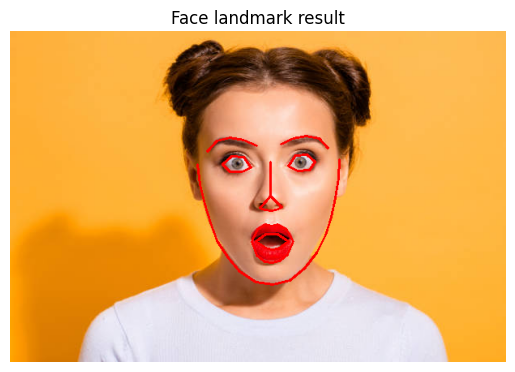

In [ ]:
#USAGE: python facial_68_Landmark.py

import dlib,cv2
import numpy as np
import matplotlib.pyplot as plt
# from facePoints import facePoints

def writeFaceLandmarksToLocalFile(faceLandmarks, fileName):
  with open(fileName, 'w') as f:
    for p in faceLandmarks.parts():
      f.write("%s %s\n" %(int(p.x),int(p.y)))

  f.close()

def landmarksToList(faceLandmarks):
    landmarks = []
    for p in faceLandmarks.parts():
        landmarks.append([p.x, p.y])
    return landmarks
# location of the model (path of the model).
Model_PATH = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"


# now from the dlib we are extracting the method get_frontal_face_detector()
# and assign that object result to frontalFaceDetector to detect face from the image with
# the help of the 68_face_landmarks.dat model
frontalFaceDetector = dlib.get_frontal_face_detector()


# Now the dlip shape_predictor class will take model and with the help of that, it will show
faceLandmarkDetector = dlib.shape_predictor(Model_PATH)

# We now reading image on which we applied our face detector
image = "/content/Test.jpeg"

# Now we are reading image using openCV
img= cv2.imread(image)
imageRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# landmarks of the face image  will be stored in output/image_k.txt
faceLandmarksOuput= "output/image"

# Now this line will try to detect all faces in an image either 1 or 2 or more faces
allFaces = frontalFaceDetector(imageRGB, 0)


print("List of all faces detected: ",len(allFaces))

# List to store landmarks of all detected faces
allFacesLandmark = []

# Below loop we will use to detect all faces one by one and apply landmarks on them

for k in range(0, len(allFaces)):
  # dlib rectangle class will detecting face so that landmark can apply inside of that area
  faceRectangleDlib = dlib.rectangle(int(allFaces[k].left()),int(allFaces[k].top()),
      int(allFaces[k].right()),int(allFaces[k].bottom()))

  # Now we are running loop on every detected face and putting landmark on that with the help of faceLandmarkDetector
  detectedLandmarks = faceLandmarkDetector(imageRGB, faceRectangleDlib)

  # count number of landmarks we actually detected on image
  if k==0:
    print("Total number of face landmarks detected ",len(detectedLandmarks.parts()))

  # Svaing the landmark one by one to the output folder
  allFacesLandmark.append(detectedLandmarks)

  # Now finally we drawing landmarks on face
  facePoints(img, detectedLandmarks)

  # fileName = 'faceLandmarksOuput' +"_"+ str(k)+ ".txt"
  # print("Lanmdark is save into ", fileName)

  # # Write landmarks to disk
  # writeFaceLandmarksToLocalFile(detectedLandmarks, fileName)

  landmarks=landmarksToList(detectedLandmarks);
  print(landmarks)
#Name of the output file
# outputNameofImage = "image.jpg"
# print("Saving output image to", outputNameofImage)
# cv2.imwrite(outputNameofImage, img)

# cv2.imshow("Face landmark result", img)
plt.imshow(img[:,:,::-1])  # Convert BGR to RGB
plt.title("Face landmark result")
plt.axis('off')  # Turn off axis labels
plt.show()


### using mediapipe

In [ ]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

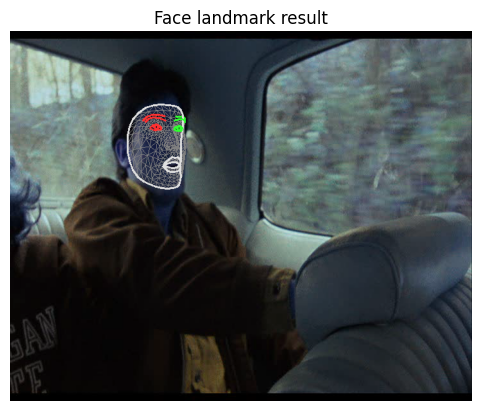

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("00001.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.imshow(annotated_image[:,:,::-1])  # Convert BGR to RGB
plt.title("Face landmark result")
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
detection_result

In [ ]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.99692082e-01, -2.38230396e-02,  6.94816234e-03,
         1.18601072e+00],
       [ 2.44070776e-02,  9.94503140e-01, -1.01821274e-01,
         9.38989103e-01],
       [-4.48428141e-03,  1.01959512e-01,  9.94778335e-01,
        -3.09500504e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


## Testing

### For ANN regression

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

landmarks=[
        [
          176.731811879757,
          149.80330667729748
        ],
        [
          175.8203461257633,
          167.81037392923892
        ],
        [
          177.3530945971501,
          186.4509676245547
        ],
        [
          181.62566496260246,
          204.0963536635601
        ],
        [
          190.83871038389626,
          218.53163553369484
        ],
        [
          202.78992415180278,
          230.9634985865357
        ],
        [
          215.64272067194324,
          241.59134082435727
        ],
        [
          229.78624323591197,
          248.48143353841786
        ],
        [
          243.71368683504596,
          250.06062532651464
        ],
        [
          254.31242745079058,
          246.7340395162329
        ],
        [
          259.89391365594275,
          235.03382340738747
        ],
        [
          262.672827950608,
          220.23354695625994
        ],
        [
          264.66924813324164,
          205.38208968666572
        ],
        [
          267.0341508003171,
          192.14759559419585
        ],
        [
          269.22712283948744,
          179.4939058014988
        ],
        [
          269.58913308780075,
          167.55386455704118
        ],
        [
          267.850946262968,
          156.4419355536656
        ],
        [
          204.09715128877005,
          130.8799234593612
        ],
        [
          212.8452622194744,
          124.10769474038956
        ],
        [
          223.6698168405871,
          122.09239413125586
        ],
        [
          234.25186949297694,
          124.39195101603661
        ],
        [
          243.28717979029125,
          129.66772826734183
        ],
        [
          255.6107731496698,
          132.40926766591863
        ],
        [
          261.5053285869794,
          129.746551300108
        ],
        [
          267.2610018317657,
          129.67341959918008
        ],
        [
          271.8019524080549,
          132.85187298852392
        ],
        [
          272.01604302923454,
          139.66690198260616
        ],
        [
          250.0521341978026,
          142.65710312214856
        ],
        [
          251.9983082077019,
          153.52513831808648
        ],
        [
          254.37916517322805,
          164.16418454175388
        ],
        [
          256.78450121944616,
          174.9460162301758
        ],
        [
          240.24841543410176,
          181.27637589290435
        ],
        [
          245.67813130331626,
          184.01687030391034
        ],
        [
          250.82559727189226,
          186.59926342281088
        ],
        [
          255.24087684574016,
          185.33223820150147
        ],
        [
          258.5475898473637,
          183.09992299341266
        ],
        [
          215.71370401724835,
          140.6305439147518
        ],
        [
          221.04591776625068,
          136.7372074030026
        ],
        [
          227.24137109711998,
          137.4226625370795
        ],
        [
          230.9881231744261,
          142.7031070855734
        ],
        [
          226.53485500249832,
          144.2191763182407
        ],
        [
          220.59549764433987,
          143.52502879923642
        ],
        [
          254.65139548264005,
          145.95997610744573
        ],
        [
          258.8735317087031,
          142.17350754920915
        ],
        [
          264.02602137248283,
          142.9096026022093
        ],
        [
          265.4985451298004,
          147.8753163555662
        ],
        [
          263.52769303346156,
          149.2426310197975
        ],
        [
          259.1210704312939,
          148.33292166037035
        ],
        [
          226.96318585134298,
          207.88781965089805
        ],
        [
          236.10655002462582,
          201.8065880856908
        ],
        [
          244.8618718591637,
          199.97951144051126
        ],
        [
          249.32084347696764,
          201.75269724394653
        ],
        [
          253.47126917106777,
          200.9060680498482
        ],
        [
          256.87170987925,
          204.09822384386334
        ],
        [
          256.090859739376,
          210.99628521905026
        ],
        [
          255.4397963779665,
          217.5152967092622
        ],
        [
          252.06459046649763,
          220.24961988306197
        ],
        [
          247.67886924789724,
          220.38779605077238
        ],
        [
          242.58309066574685,
          219.5286887124571
        ],
        [
          234.76862926538467,
          215.4371505997148
        ],
        [
          230.09834120565012,
          207.80462692157354
        ],
        [
          244.159277596036,
          205.42277027829016
        ],
        [
          248.60172351902787,
          206.00091235772098
        ],
        [
          252.56144473443754,
          206.1217209805979
        ],
        [
          254.09062982287435,
          210.31233280750624
        ],
        [
          252.33592200456175,
          212.5726388637228
        ],
        [
          248.26083906734863,
          212.91030759074772
        ],
        [
          243.69387142284722,
          211.98968609120882
        ]
      ]



def normalize_landmarks(landmarks):
    """
    Normalize landmarks by translating them to the origin and scaling them based on the distance between two reference points.
    """
    # Select two reference landmarks (e.g., eye corners)
    ref_landmark_1 = np.array(landmarks[36])  # Left eye corner
    ref_landmark_2 = np.array(landmarks[45])  # Right eye corner

    # Calculate the origin (center of the reference landmarks)
    origin = (ref_landmark_1 + ref_landmark_2) / 2

    # Calculate the scaling factor (distance between the reference landmarks)
    scaling_factor = np.linalg.norm(ref_landmark_2 - ref_landmark_1)

    # Translate and scale the landmarks
    normalized_landmarks = [(np.array(landmark) - origin) / scaling_factor for landmark in landmarks]

    # Convert landmarks from NumPy arrays to Python lists
    normalized_landmarks = [landmark.tolist() for landmark in normalized_landmarks]

    return normalized_landmarks


# Load the saved model
model_path = '/content/Models/valence_model.h5'
loaded_model = load_model(model_path)

origin_x,origin_y = landmarks[0]
# Assuming you have your new data (X_new) prepared for prediction
# X_new = [[x - origin_x, y - origin_y] for x, y in landmarks]


X_new = normalize_landmarks(landmarks)

X_new = np.array(X_new).flatten()

X_new_reshaped = X_new.reshape(1, -1)
# changed
X_new_pca = pca.transform(X_new_reshaped)

normalized_landmarks = [list(landmark) for landmark in X_new_pca]
# Preprocess new data (X_new) using the same scaler used for training data
# scaler = StandardScaler()
# X_new_scaled = scaler.transform(X_new)  # Assuming 'scaler' is the StandardScaler used for training data

# Make predictions on new data

X_new_scaled = np.array(normalized_landmarks).flatten()

X_new_scaled = np.array(X_new_scaled).reshape(1, -1)
# print(landmarks)
# prev_landmarks = None
# X_new_scaled = engineer_features(landmarks,prev_landmarks)

# print(X_new)
# print(X_new_scaled)


predictions = loaded_model.predict(X_new_scaled)

# Extract predicted valence and arousal values
# predicted_valence = predictions[:, 0]
# predicted_arousal = predictions[:, 1]

# Print or use predicted values as needed
# print("Predicted Valence:", predicted_valence)
# print("Predicted Arousal:", predicted_arousal)

print(predictions)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# landmarks=[
#         [
#           176.731811879757,
#           149.80330667729748
#         ],
#         [
#           175.8203461257633,
#           167.81037392923892
#         ],
#         [
#           177.3530945971501,
#           186.4509676245547
#         ],
#         [
#           181.62566496260246,
#           204.0963536635601
#         ],
#         [
#           190.83871038389626,
#           218.53163553369484
#         ],
#         [
#           202.78992415180278,
#           230.9634985865357
#         ],
#         [
#           215.64272067194324,
#           241.59134082435727
#         ],
#         [
#           229.78624323591197,
#           248.48143353841786
#         ],
#         [
#           243.71368683504596,
#           250.06062532651464
#         ],
#         [
#           254.31242745079058,
#           246.7340395162329
#         ],
#         [
#           259.89391365594275,
#           235.03382340738747
#         ],
#         [
#           262.672827950608,
#           220.23354695625994
#         ],
#         [
#           264.66924813324164,
#           205.38208968666572
#         ],
#         [
#           267.0341508003171,
#           192.14759559419585
#         ],
#         [
#           269.22712283948744,
#           179.4939058014988
#         ],
#         [
#           269.58913308780075,
#           167.55386455704118
#         ],
#         [
#           267.850946262968,
#           156.4419355536656
#         ],
#         [
#           204.09715128877005,
#           130.8799234593612
#         ],
#         [
#           212.8452622194744,
#           124.10769474038956
#         ],
#         [
#           223.6698168405871,
#           122.09239413125586
#         ],
#         [
#           234.25186949297694,
#           124.39195101603661
#         ],
#         [
#           243.28717979029125,
#           129.66772826734183
#         ],
#         [
#           255.6107731496698,
#           132.40926766591863
#         ],
#         [
#           261.5053285869794,
#           129.746551300108
#         ],
#         [
#           267.2610018317657,
#           129.67341959918008
#         ],
#         [
#           271.8019524080549,
#           132.85187298852392
#         ],
#         [
#           272.01604302923454,
#           139.66690198260616
#         ],
#         [
#           250.0521341978026,
#           142.65710312214856
#         ],
#         [
#           251.9983082077019,
#           153.52513831808648
#         ],
#         [
#           254.37916517322805,
#           164.16418454175388
#         ],
#         [
#           256.78450121944616,
#           174.9460162301758
#         ],
#         [
#           240.24841543410176,
#           181.27637589290435
#         ],
#         [
#           245.67813130331626,
#           184.01687030391034
#         ],
#         [
#           250.82559727189226,
#           186.59926342281088
#         ],
#         [
#           255.24087684574016,
#           185.33223820150147
#         ],
#         [
#           258.5475898473637,
#           183.09992299341266
#         ],
#         [
#           215.71370401724835,
#           140.6305439147518
#         ],
#         [
#           221.04591776625068,
#           136.7372074030026
#         ],
#         [
#           227.24137109711998,
#           137.4226625370795
#         ],
#         [
#           230.9881231744261,
#           142.7031070855734
#         ],
#         [
#           226.53485500249832,
#           144.2191763182407
#         ],
#         [
#           220.59549764433987,
#           143.52502879923642
#         ],
#         [
#           254.65139548264005,
#           145.95997610744573
#         ],
#         [
#           258.8735317087031,
#           142.17350754920915
#         ],
#         [
#           264.02602137248283,
#           142.9096026022093
#         ],
#         [
#           265.4985451298004,
#           147.8753163555662
#         ],
#         [
#           263.52769303346156,
#           149.2426310197975
#         ],
#         [
#           259.1210704312939,
#           148.33292166037035
#         ],
#         [
#           226.96318585134298,
#           207.88781965089805
#         ],
#         [
#           236.10655002462582,
#           201.8065880856908
#         ],
#         [
#           244.8618718591637,
#           199.97951144051126
#         ],
#         [
#           249.32084347696764,
#           201.75269724394653
#         ],
#         [
#           253.47126917106777,
#           200.9060680498482
#         ],
#         [
#           256.87170987925,
#           204.09822384386334
#         ],
#         [
#           256.090859739376,
#           210.99628521905026
#         ],
#         [
#           255.4397963779665,
#           217.5152967092622
#         ],
#         [
#           252.06459046649763,
#           220.24961988306197
#         ],
#         [
#           247.67886924789724,
#           220.38779605077238
#         ],
#         [
#           242.58309066574685,
#           219.5286887124571
#         ],
#         [
#           234.76862926538467,
#           215.4371505997148
#         ],
#         [
#           230.09834120565012,
#           207.80462692157354
#         ],
#         [
#           244.159277596036,
#           205.42277027829016
#         ],
#         [
#           248.60172351902787,
#           206.00091235772098
#         ],
#         [
#           252.56144473443754,
#           206.1217209805979
#         ],
#         [
#           254.09062982287435,
#           210.31233280750624
#         ],
#         [
#           252.33592200456175,
#           212.5726388637228
#         ],
#         [
#           248.26083906734863,
#           212.91030759074772
#         ],
#         [
#           243.69387142284722,
#           211.98968609120882
#         ]
#       ]


# actual arousal = 3
landmarks = [
        [
          415.01509437518024,
          248.3560464531049
        ],
        [
          415.72340239630034,
          270.1179955791145
        ],
        [
          419.20932804796587,
          292.12759252980004
        ],
        [
          424.06949746435816,
          313.64866096251745
        ],
        [
          431.8541700658709,
          334.32060064690444
        ],
        [
          442.3646811615216,
          353.21169882661206
        ],
        [
          456.2266116709631,
          369.93761241706926
        ],
        [
          474.60856096316303,
          382.6581078054771
        ],
        [
          494.53495301318725,
          385.64376719987666
        ],
        [
          512.2806767434442,
          381.50483922081645
        ],
        [
          525.1717041463005,
          367.47870669404267
        ],
        [
          533.8903034367402,
          348.9450622636524
        ],
        [
          540.4662504493834,
          327.4149549874541
        ],
        [
          544.5424214395489,
          306.12867042229783
        ],
        [
          546.1674797090429,
          285.0973782381994
        ],
        [
          546.3803149408218,
          264.044199213956
        ],
        [
          544.2195713208214,
          243.62412505376443
        ],
        [
          433.8512742758094,
          229.479968825561
        ],
        [
          442.65527552316155,
          217.47048255194582
        ],
        [
          455.5207508688755,
          213.0596822487628
        ],
        [
          468.80158541060496,
          214.12579189146933
        ],
        [
          479.95537993747394,
          219.1104970647128
        ],
        [
          499.3338828934916,
          216.11214957171183
        ],
        [
          508.73358584432,
          207.96119565125116
        ],
        [
          519.3880580095112,
          204.17950745145822
        ],
        [
          530.5754627475977,
          205.65610747053233
        ],
        [
          537.5036121412758,
          214.72681555327802
        ],
        [
          492.01022729456287,
          237.40394689109706
        ],
        [
          493.7534884386862,
          252.82005327293658
        ],
        [
          495.6316707220269,
          267.79584872412875
        ],
        [
          497.47466974274477,
          283.2755953885813
        ],
        [
          482.8237371960947,
          294.43282711821604
        ],
        [
          489.64167526145087,
          296.28288115970656
        ],
        [
          496.25680259477446,
          298.50353266716235
        ],
        [
          502.617272511839,
          295.49668710234704
        ],
        [
          507.7536057491112,
          292.2060848155764
        ],
        [
          447.78785408510225,
          245.30214146271695
        ],
        [
          453.92143544924664,
          237.5397346613532
        ],
        [
          463.53576458396685,
          236.8282765683044
        ],
        [
          470.67083931806434,
          244.07962953407807
        ],
        [
          463.6917522399184,
          247.7796544015934
        ],
        [
          454.51594375537803,
          248.49121506694306
        ],
        [
          508.0575292907485,
          240.09807249348586
        ],
        [
          513.9315328403708,
          231.04960097860703
        ],
        [
          522.7930910469605,
          229.42211311242173
        ],
        [
          528.1044969992793,
          235.79439955214227
        ],
        [
          524.48790458983,
          240.46373265963135
        ],
        [
          516.423344186472,
          241.68554383125092
        ],
        [
          468.9751251498035,
          334.04405242803205
        ],
        [
          477.6306005239261,
          323.51300361862235
        ],
        [
          488.02865573903534,
          318.6580679857394
        ],
        [
          495.5289082407055,
          320.18743474689876
        ],
        [
          503.18122765351404,
          317.9213948981624
        ],
        [
          512.2676810420613,
          321.3373099593964
        ],
        [
          517.8669151310054,
          329.7340640217139
        ],
        [
          513.2513270402874,
          344.29696375237955
        ],
        [
          504.62519533635395,
          350.7886576317996
        ],
        [
          496.3463733213088,
          352.27914230637776
        ],
        [
          488.23639953284913,
          351.898693552351
        ],
        [
          477.7055332383769,
          347.1724786442825
        ],
        [
          473.67256574221625,
          333.50143347031735
        ],
        [
          488.19559800129497,
          326.9950770846002
        ],
        [
          495.6056922463553,
          326.8161923314035
        ],
        [
          503.3466021172158,
          325.8434415672229
        ],
        [
          513.8432678438163,
          330.3504164026429
        ],
        [
          503.7763018070255,
          339.6784896458147
        ],
        [
          495.806948351228,
          341.27013278102464
        ],
        [
          488.18768444279647,
          340.75307922441937
        ]
      ]

def normalize_landmarks(landmarks):
    """
    Normalize landmarks by translating them to the origin and scaling them based on the distance between two reference points.
    """
    # Select two reference landmarks (e.g., eye corners)
    ref_landmark_1 = np.array(landmarks[36])  # Left eye corner
    ref_landmark_2 = np.array(landmarks[45])  # Right eye corner

    # Calculate the origin (center of the reference landmarks)
    origin = (ref_landmark_1 + ref_landmark_2) / 2

    # Calculate the scaling factor (distance between the reference landmarks)
    scaling_factor = np.linalg.norm(ref_landmark_2 - ref_landmark_1)

    # Translate and scale the landmarks
    normalized_landmarks = [(np.array(landmark) - origin) / scaling_factor for landmark in landmarks]

    # Convert landmarks from NumPy arrays to Python lists
    normalized_landmarks = [landmark.tolist() for landmark in normalized_landmarks]

    return normalized_landmarks


# Load the saved model
model_path = '/content/Models/arousal_model.h5'
loaded_model = load_model(model_path)

origin_x,origin_y = landmarks[0]
# Assuming you have your new data (X_new) prepared for prediction
# X_new = [[x - origin_x, y - origin_y] for x, y in landmarks]


X_new = normalize_landmarks(landmarks)

X_new = np.array(X_new).flatten()

X_new_reshaped = X_new.reshape(1, -1)
# changed
X_new_pca = pca.transform(X_new_reshaped)

normalized_landmarks = [list(landmark) for landmark in X_new_pca]
# Preprocess new data (X_new) using the same scaler used for training data
# scaler = StandardScaler()
# X_new_scaled = scaler.transform(X_new)  # Assuming 'scaler' is the StandardScaler used for training data

# Make predictions on new data

X_new_scaled = np.array(normalized_landmarks).flatten()

X_new_scaled = np.array(X_new_scaled).reshape(1, -1)
# print(landmarks)
# prev_landmarks = None
# X_new_scaled = engineer_features(landmarks,prev_landmarks)

# print(X_new)
# print(X_new_scaled)


predictions = loaded_model.predict(X_new_scaled)

# Extract predicted valence and arousal values
# predicted_valence = predictions[:, 0]
# predicted_arousal = predictions[:, 1]

# Print or use predicted values as needed
# print("Predicted Valence:", predicted_valence)
# print("Predicted Arousal:", predicted_arousal)

print(predictions)

### For feature ANN regression

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

landmarks=[
        [
          233.17260277683778,
          205.5002536838382
        ],
        [
          233.70315590810924,
          236.02134245562272
        ],
        [
          239.02157109625378,
          267.77775207675637
        ],
        [
          248.01526778754442,
          297.4238422049498
        ],
        [
          263.02917481818804,
          322.6073323221489
        ],
        [
          281.09555806580045,
          344.5439855299326
        ],
        [
          298.2935609732693,
          363.2660901395375
        ],
        [
          318.07193350655757,
          375.5268693159058
        ],
        [
          338.2228603713815,
          375.8694756172861
        ],
        [
          355.6361470613405,
          368.28497748436376
        ],
        [
          367.30956435571136,
          348.0526460823674
        ],
        [
          376.2288628441042,
          322.69808994983333
        ],
        [
          384.4469281444751,
          295.4316556290103
        ],
        [
          390.7918036698822,
          268.9930717938601
        ],
        [
          393.89172791972925,
          242.57989595999723
        ],
        [
          393.64269333723684,
          215.55283767633892
        ],
        [
          390.085801110263,
          188.90380448271208
        ],
        [
          256.33762710463793,
          190.36598037254
        ],
        [
          266.11039080538984,
          178.2049220652724
        ],
        [
          280.6379643033732,
          173.16241592996502
        ],
        [
          295.9277212063574,
          174.30843943502373
        ],
        [
          309.913784331515,
          179.29992437806192
        ],
        [
          340.75479779401485,
          174.47057014763288
        ],
        [
          351.4849828492778,
          165.62283685393552
        ],
        [
          363.008152005092,
          160.93193401274743
        ],
        [
          374.55652988497343,
          161.3908277485932
        ],
        [
          381.94739814377976,
          169.9107769691497
        ],
        [
          327.8919877635314,
          206.98806877934214
        ],
        [
          330.8384356408912,
          228.74550110364328
        ],
        [
          334.0136818525512,
          250.1672448304429
        ],
        [
          337.2675017112702,
          271.79049330944713
        ],
        [
          316.0467591337517,
          279.32173435601777
        ],
        [
          325.4341374933541,
          282.84719076895317
        ],
        [
          335.10133886040154,
          286.258691642648
        ],
        [
          344.0361032133159,
          281.29250205047526
        ],
        [
          351.1301834935464,
          275.62299517247544
        ],
        [
          275.1531443632893,
          213.3350866704061
        ],
        [
          282.9148165068621,
          206.63802149074277
        ],
        [
          294.1238187354071,
          205.9148780159479
        ],
        [
          302.90662177136716,
          212.1960888780473
        ],
        [
          294.4899430720263,
          217.32510855181266
        ],
        [
          283.50788161578026,
          218.29372886777765
        ],
        [
          344.92332030039296,
          206.1876148493072
        ],
        [
          352.1599784697118,
          197.11116629048345
        ],
        [
          362.5758435197436,
          195.0372911486373
        ],
        [
          369.2661495082968,
          199.49793685825895
        ],
        [
          364.6164135426208,
          206.11315968141665
        ],
        [
          355.0446384425863,
          207.9512270432974
        ],
        [
          299.7615469111468,
          312.24618087796995
        ],
        [
          312.83205857767285,
          308.68257324241745
        ],
        [
          325.1917054657195,
          306.6721628839889
        ],
        [
          333.6855585426905,
          308.0091287155362
        ],
        [
          342.1956825761624,
          304.81747488943347
        ],
        [
          351.7846934114029,
          303.97578176799783
        ],
        [
          359.0722781289784,
          304.88094008303943
        ],
        [
          352.52066675549617,
          319.6943948844066
        ],
        [
          343.54513123962596,
          327.8707300722362
        ],
        [
          334.36232715240095,
          330.3509727980217
        ],
        [
          325.3354765001959,
          330.2430245548777
        ],
        [
          312.92018965722417,
          325.4401684123776
        ],
        [
          304.76090908191355,
          312.7622259069496
        ],
        [
          325.48415939660873,
          314.0560701813285
        ],
        [
          333.87349222473415,
          314.0387814354456
        ],
        [
          342.4389801354963,
          311.8147587960913
        ],
        [
          354.63509093837905,
          306.77178643055043
        ],
        [
          342.3854992532061,
          315.4886147631151
        ],
        [
          333.74133660291716,
          318.27483378111185
        ],
        [
          325.25539364644465,
          318.1995056072922
        ]
      ]


def normalize_landmarks(landmarks):
    """
    Normalize landmarks by translating them to the origin and scaling them based on the distance between two reference points.
    """
    # Select two reference landmarks (e.g., eye corners)
    ref_landmark_1 = np.array(landmarks[36])  # Left eye corner
    ref_landmark_2 = np.array(landmarks[45])  # Right eye corner

    # Calculate the origin (center of the reference landmarks)
    origin = (ref_landmark_1 + ref_landmark_2) / 2

    # Calculate the scaling factor (distance between the reference landmarks)
    scaling_factor = np.linalg.norm(ref_landmark_2 - ref_landmark_1)

    # Translate and scale the landmarks
    normalized_landmarks = [(np.array(landmark) - origin) / scaling_factor for landmark in landmarks]

    # Convert landmarks from NumPy arrays to Python lists
    normalized_landmarks = [landmark.tolist() for landmark in normalized_landmarks]

    return normalized_landmarks


# Load the saved model
model_path = '/content/Models/valence_feature_model.h5'
loaded_model = load_model(model_path)

X_new = np.array(normalize_landmarks(landmarks))


X_new = engineer_features(X_new)

X_new = np.array(X_new)
# normalized_landmarks = [list(landmark) for landmark in X_new]

# Make predictions on new data

# X_new_faltten = np.array(normalized_landmarks).flatten()

X_new_reshape = np.array(X_new).reshape(1, -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_new_reshape)

# print(landmarks)
# prev_landmarks = None
# X_new_scaled = engineer_features(landmarks,prev_landmarks)

# print(X_new)
# print(X_new_scaled)


predictions = loaded_model.predict(X_test_scaled)


# Extract predicted valence and arousal values
# predicted_valence = predictions[:, 0]
# predicted_arousal = predictions[:, 1]

# Print or use predicted values as needed
# print("Predicted Valence:", predicted_valence)
# print("Predicted Arousal:", predicted_arousal)

print(predictions)


1/1 [==============================] - 0s 102ms/step
[[0.5508603]]
